<a href="https://colab.research.google.com/github/KunalGoyal0601/Kaggle-submission-/blob/main/Calories__Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

warnings.filterwarnings('ignore')

**Data loding**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/calories_train.csv')
test=pd.read_csv('/content/drive/MyDrive/calories_test.csv')
sub=pd.read_csv('/content/drive/MyDrive/calories_sample_submission.csv')

In [ ]:
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


**Distribution of target variable(Calories)**

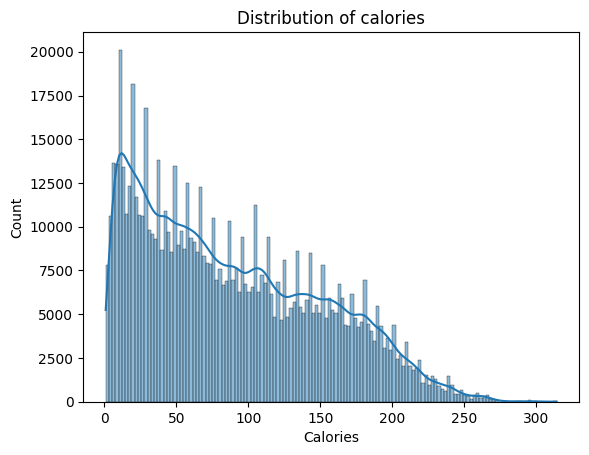

In [ ]:
sns.histplot(data=df, x= 'Calories',kde=True)
plt.title('Distribution of calories')
plt.show()

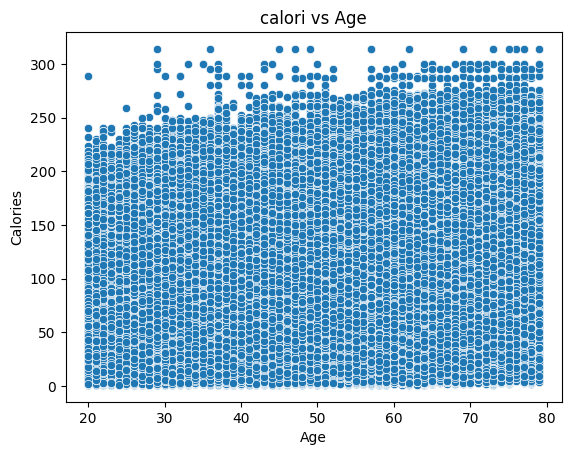

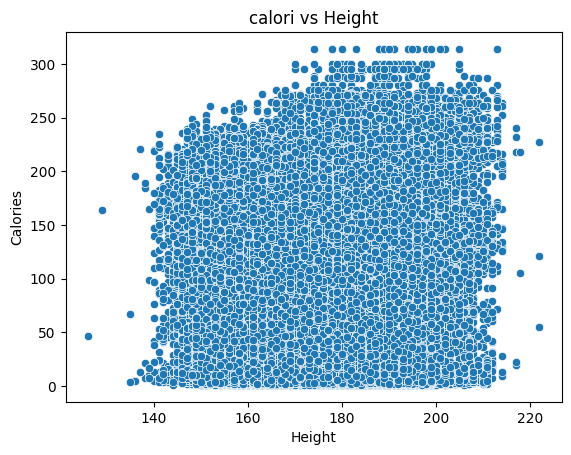

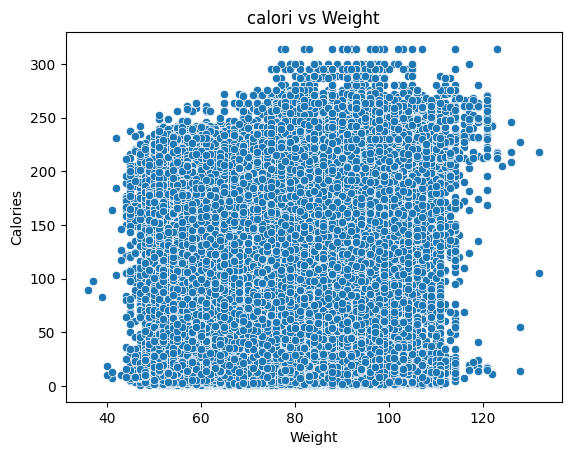

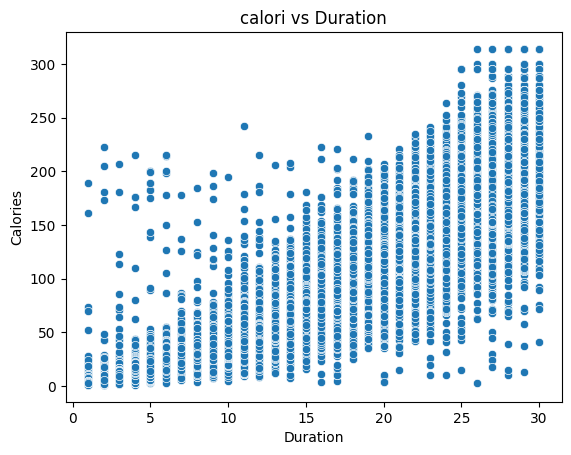

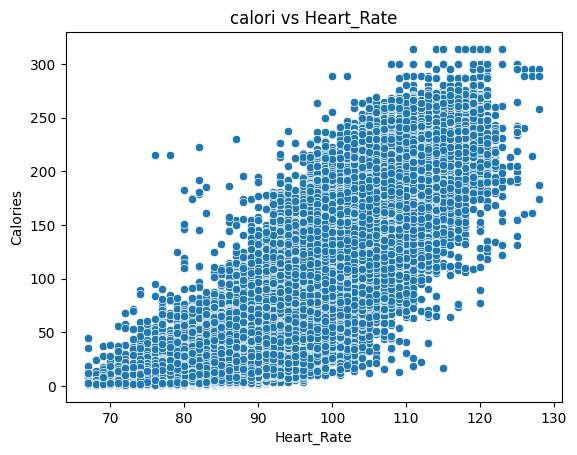

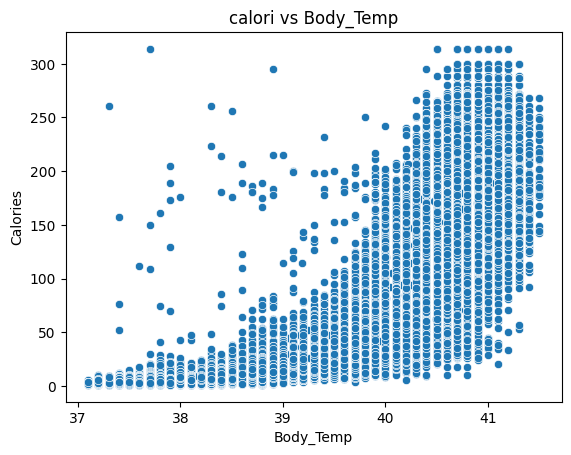

In [ ]:
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

for feature in numerical_features:
 sns.scatterplot(data=df, x=feature,y='Calories')
 plt.title(f'calori vs {feature}')
 plt.show()

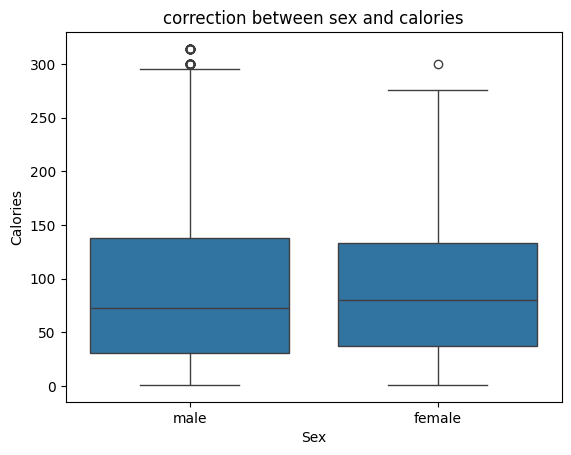

In [ ]:
sns.boxplot(data=df,x='Sex',y='Calories')
plt.title('correction between sex and calories')
plt.show()

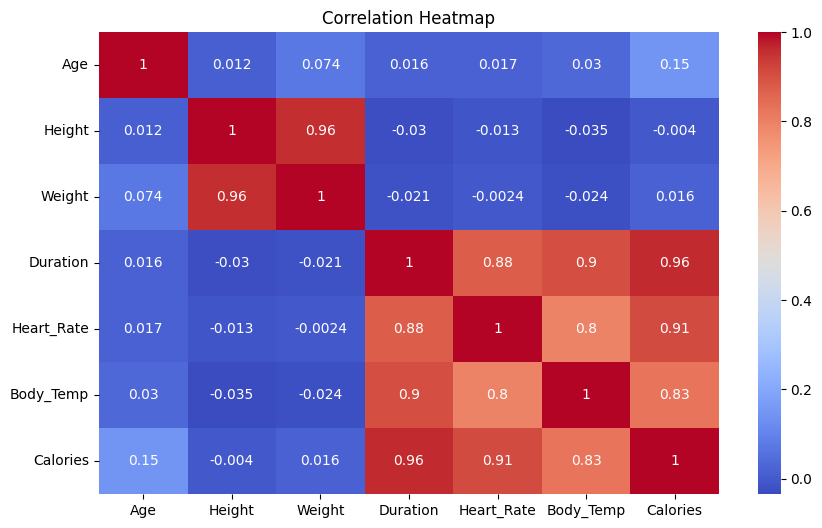

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_features + ['Calories']].corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

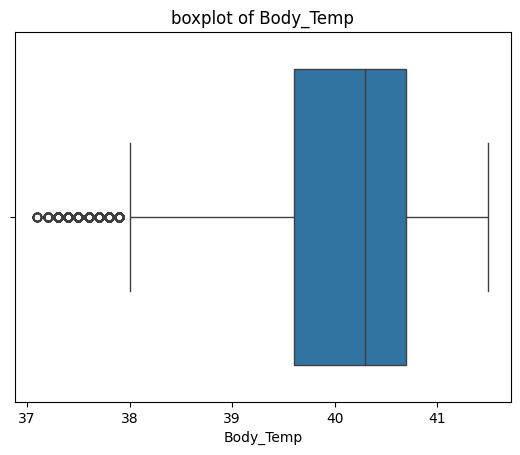

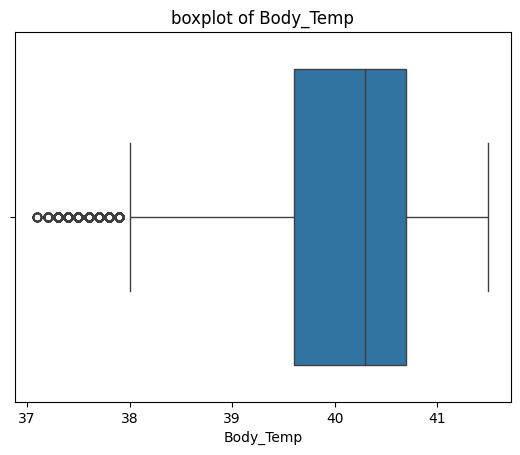

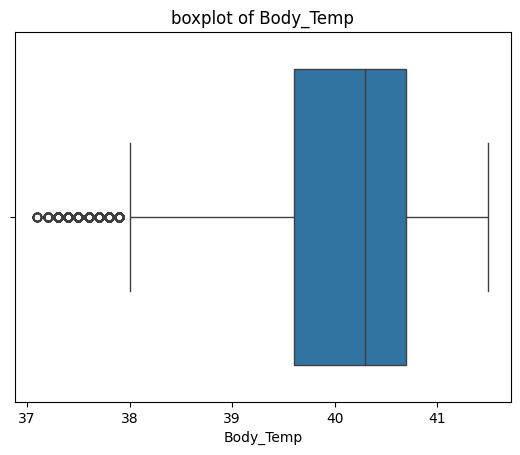

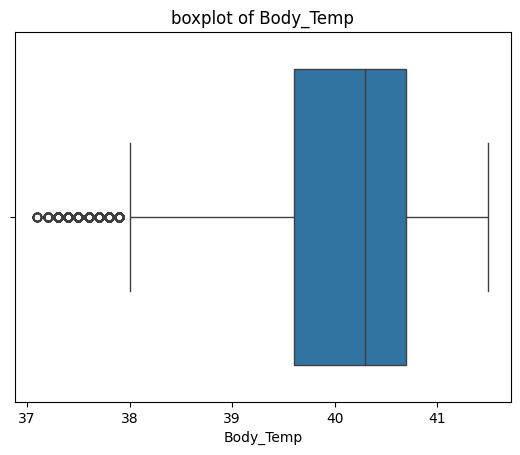

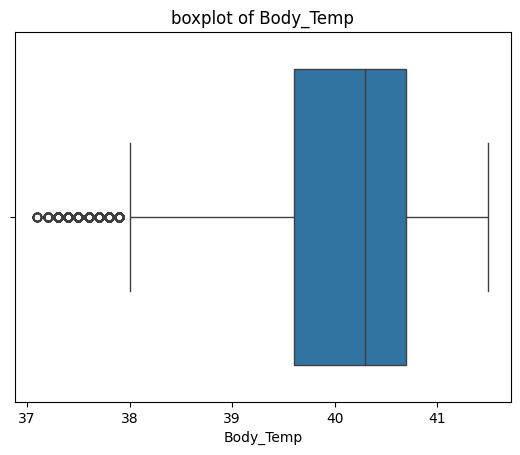

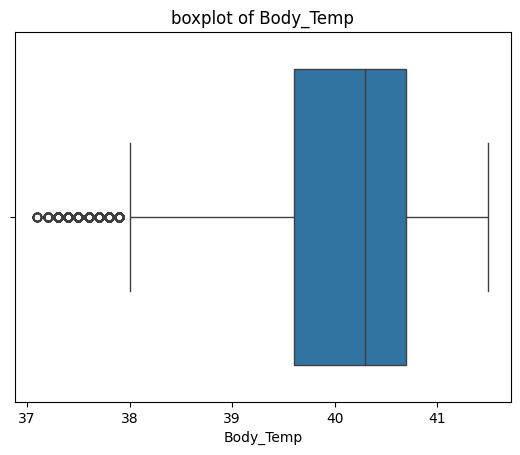

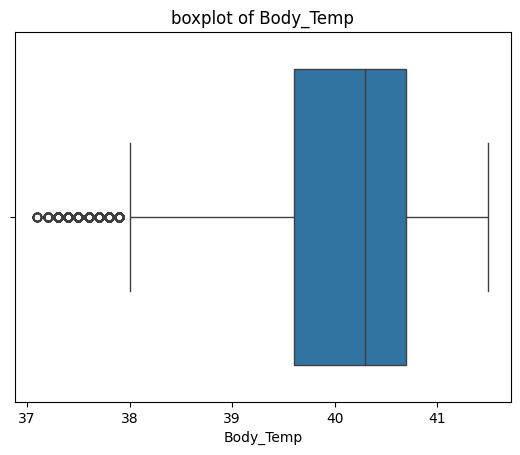

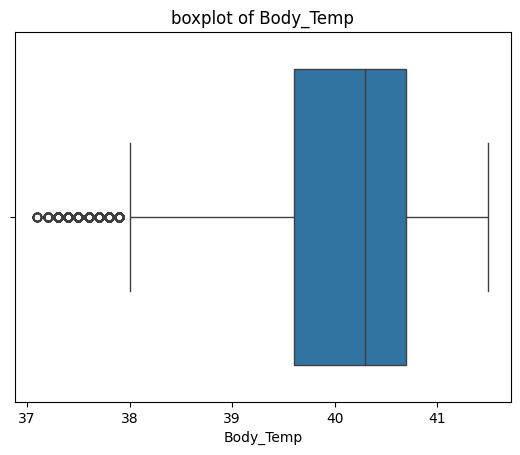

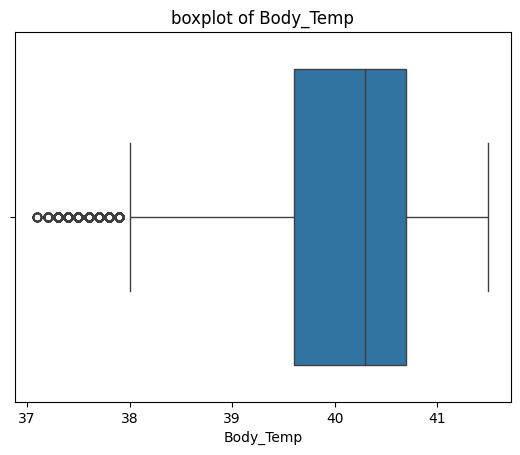

In [ ]:
for numerical_features in feature:
 sns.boxplot(data=df,x=feature)
 plt.title(f'boxplot of {feature}')
 plt.show()

***Cleaning data***

In [ ]:
df.drop('id', axis=1, inplace=True)
test_ids = test['id']  # Save for submission
test.drop('id', axis=1, inplace=True)

In [ ]:
#Checking Null Value if any
print(df.isnull().sum())

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


***Feature engineering***

In [ ]:
# Creating a new feature 'IMC' (Body Mass Index) by dividing Weight by Height squared
# Creating a new feature 'Intensity' by dividing Heart Rate by Duration

df['IMC'] = df['Weight'] / (df['Height'] ** 2)
test['IMC'] = test['Weight'] / (test['Height'] ** 2)

df['Intensity'] = df['Heart_Rate']/ df['Duration']
test['Intensity'] = test['Heart_Rate'] / test['Duration']

***1. Removing outlinear***

In [ ]:
def _remove_outliers(df):
    cleaned_df = df.copy()
    for col in cleaned_df.columns:
        if cleaned_df[col].dtype in ['float64', 'int64']:

            Q1 = cleaned_df[col].quantile(0.20)
            Q3 = cleaned_df[col].quantile(0.80)
            IQR = Q3 - Q1

            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR

            cleaned_df[col] = cleaned_df[col].apply(
                lambda x: x if pd.isnull(x) or (lower_limit <= x <= upper_limit) else None
            )

    return cleaned_df

df = _remove_outliers(df)
test = _remove_outliers(test)

***2 filling missing values***

In [ ]:
def _fill_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].fillna(df[column].mode()[0])
        else:
            df[column] = df[column].fillna(df[column].mean())
    return df

df = _fill_missing_values(df)
test = _fill_missing_values(test)

***one hot incoding***

In [ ]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

In [ ]:
def _one_hot_encode_columns(df, categorical_columns):
    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    return df_encoded

df = _one_hot_encode_columns(df,categorical_columns)
test = _one_hot_encode_columns(test, categorical_columns)

***Train test split***

In [ ]:
# Splitting the data
X_train = df.drop('Calories', axis=1).values.astype(np.float32)
y_train = df['Calories'].values.astype(np.float32)
X_test = test.values.astype(np.float32)

# Applying log1p transformation to the target variable
y_train_log = np.log1p(y_train)

***Applying mimaxscaling***

In [ ]:
Scaler=MinMaxScaler()
X_train_scaled=Scaler.fit_transform(X_train)
X_test_scaled=Scaler.transform(X_test)

***XGB Retraction***

In [ ]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    learning_rate=0.5,
    max_depth=5,
    random_state=42,
    eval_metric="rmsle",
    tree_method="hist"
)

model.fit(
    X_train_scaled, y_train_log,
    eval_set=[(X_train_scaled, y_train_log)],
    verbose=0
)

y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

In [ ]:
#test = test.values.astype(np.float32)
y_test = model.predict(X_test_scaled).flatten()

submission = pd.DataFrame({
    'id': test_ids,
    'Calories': y_pred
})
submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files

# Download the submission filed
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission.head()

,id,Calories
0,750000,27.482582
1,750001,107.862015
2,750002,87.190887
3,750003,125.631210
4,750004,75.806702
